In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from __future__ import print_function
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [3]:
# open notebook with this :: jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000

In [4]:
from PIL import Image
import glob


# Retrieve and resize images

marge = []
for filename in glob.glob('../../../Data/Simpsons/simpsons_dataset/marge_simpson/*.jpg'): 
    im=Image.open(filename)
    size =im.size   # get the size of the input image
    ratio = 0.1  # reduced the size to 90% of the input image
    reduced_size = int(size[0] * ratio), int(size[1] * ratio)     
    im_resized = im.resize(reduced_size, Image.ANTIALIAS)
    marge.append(np.asarray(im_resized))
    
homer = []
for filename in glob.glob('../../../Data/Simpsons/simpsons_dataset/homer_simpson/*.jpg'): 
    im=Image.open(filename)
    size =im.size   # get the size of the input image
    ratio = 0.1  # reduced the size to 90% of the input image
    reduced_size = int(size[0] * ratio), int(size[1] * ratio)     
    im_resized = im.resize(reduced_size, Image.ANTIALIAS)
    homer.append(np.asarray(im_resized))

In [5]:
homer[0].shape

(43, 57, 3)

In [6]:
len(homer)

1163

In [7]:
len(marge)

1291

In [8]:
# Convert to grayscale
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def graythem(train):
    newtrain = []
    greysize = []
    for x in train:
        greysize.append(x.shape[:2])
        data = np.concatenate(rgb2gray(x), axis=0)
        newtrain.append(data)
    return newtrain, greysize

In [9]:
greymarge, margesize = graythem(marge)
greyhomer, homersize = graythem(homer)

In [20]:
greymarge[0]

array([115.3648, 115.3217, 111.4639, ..., 105.4133,  99.149 , 120.6814])

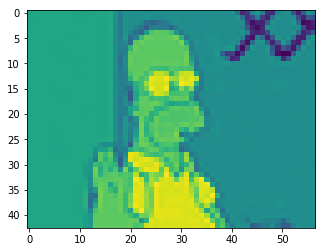

In [32]:
plt.imshow(np.asarray(greyhomer[0]).reshape(homersize[0]))

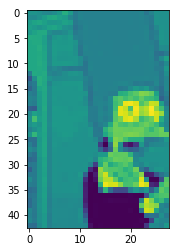

In [11]:
plt.imshow(np.asarray(greymarge[0]).reshape(margesize[0]))

In [10]:
# Make an array is we are preserving color 

def make1darray(images):
    newgroup = []
    sizes = []
    for x in images:
        count = 0
        count2 = 3
        darr = x.ravel()
        size = x.shape[0] * x.shape[1]
        img = []
        for piece in range(size):
            pixelrgb = darr[count:count2]
            count = count+3
            count2 = count2+3
            img.append(pixelrgb)
        newgroup.append(img)
        sizes.append(x.shape)
    return newgroup, sizes

In [43]:
homer1d, homer1dsize = make1darray(greyhomer)

IndexError: tuple index out of range

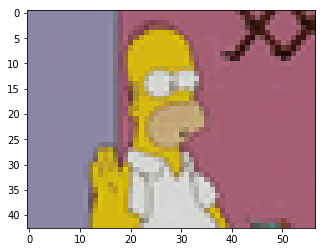

In [9]:
plt.imshow(homer[0])

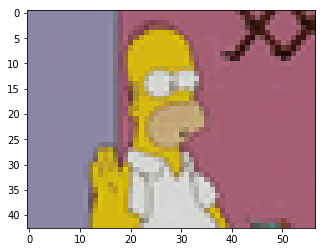

In [10]:
plt.imshow(np.asarray(homer1d[0]).reshape(homer1dsize[0]))

In [11]:
marge1d, marge1dsize = make1darray(greymarge)

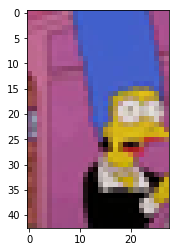

In [13]:
plt.imshow(marge[0])

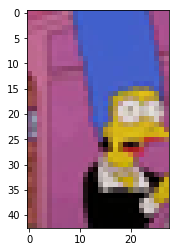

In [14]:
plt.imshow(np.asarray(marge1d[0]).reshape(marge1dsize[0]))

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(greyhomer, np.ones(len(greyhomer)), test_size=0, random_state=0)
X_trainm, X_testm, Y_trainm, Y_test = train_test_split(greymarge, np.zeros(len(greymarge)), test_size=0, random_state=0)

In [24]:
fullsetX = np.concatenate((X_train, X_trainm), axis=0)
fullsetY = np.concatenate((Y_train, Y_trainm), axis=0)

In [28]:
fullsetY[20:]

array([1., 1., 1., ..., 0., 0., 0.])

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(fullsetX, fullsetY, test_size=.3, random_state=0)

In [29]:
Y_train

array([1., 0., 1., ..., 1., 1., 0.])

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


# Set the logistic parameters by cross-validation
tuned_parameters = {'C': [1, 10, 100, 1000]}

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/home/ebicher/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ebicher/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: setting an array element with a sequence.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import time

# initialize the RBM + Logistic Regression pipeline
rbm = BernoulliRBM()
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])
 

print ("SEARCHING RBM + LOGISTIC REGRESSION")
params = {
"rbm__learning_rate": [0.1, 0.01, 0.001],
"rbm__n_iter": [20, 40, 80],
"rbm__n_components": [20, 50, 100],
"logistic__C": [1.0, 10.0]}
 
# perform a grid search over the parameter
start = time.time()
gs = GridSearchCV(classifier, params, n_jobs = -1, verbose = 1)
gs.fit(X_train, Y_train)
 
# print diagnostic information to the user and grab the
# best model
print ("\ndone in %0.3fs" % (time.time() - start))
print ("best score: %0.3f" % (gs.best_score_))
print ("RBM + LOGISTIC REGRESSION PARAMETERS")
bestParams = gs.best_estimator_.get_params()
 
# loop over the parameters and print each of them out
# so they can be manually set
for p in sorted(params.keys()):
    print ("\t %s: %f" % (p, bestParams[p]))

SEARCHING RBM + LOGISTIC REGRESSION
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/ebicher/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: setting an array element with a sequence.

In [26]:
# Set up Models
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training


rbm.learning_rate = 0.1
rbm.n_iter = 20
rbm.n_components = 20

logistic.C = 1
logistic.kernal = 'linear'

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 1.
raw_pixel_classifier.fit(X_train, Y_train)


ValueError: setting an array element with a sequence.